Epoch 1/20 - Loss: 2.4917
Epoch 2/20 - Loss: 1.5868
Epoch 3/20 - Loss: 1.5404
Epoch 4/20 - Loss: 1.5345
Epoch 5/20 - Loss: 1.5235
Epoch 6/20 - Loss: 1.5012
Epoch 7/20 - Loss: 1.4984
Epoch 8/20 - Loss: 1.4835
Epoch 9/20 - Loss: 1.4706
Epoch 10/20 - Loss: 1.4720
Epoch 11/20 - Loss: 1.4581
Epoch 12/20 - Loss: 1.4397
Epoch 13/20 - Loss: 1.4487
Epoch 14/20 - Loss: 1.4356
Epoch 15/20 - Loss: 1.4266
Epoch 16/20 - Loss: 1.4121
Epoch 17/20 - Loss: 1.4417
Epoch 18/20 - Loss: 1.4016
Epoch 19/20 - Loss: 1.4016
Epoch 20/20 - Loss: 1.4037


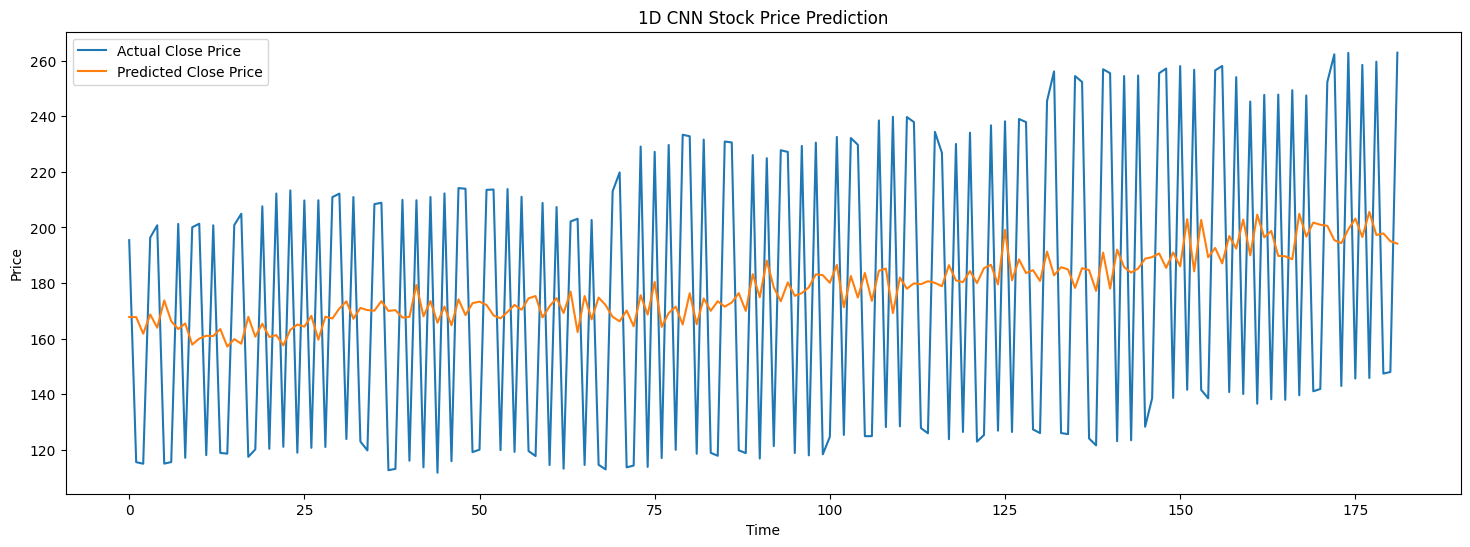

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load Data
df = pd.read_excel("/content/A_AAPL_two_years.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")
close_prices = df[['Close']].values

# Scaling
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# Create sequences
SEQ_LEN = 60

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_close, SEQ_LEN)

# Train/Test Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

# Dataset & Dataloader
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=32, shuffle=True)

# 1D CNN Model (Auto shape detection)
class CNN1DModel(nn.Module):
    def __init__(self, input_channels=1, output_size=1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.flatten_dim = None
        self.fc = None

    def compute_flatten_dim(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        self.flatten_dim = x.numel() // x.shape[0]
        self.fc = nn.Linear(self.flatten_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        if self.fc is None:
            self.compute_flatten_dim(x)

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

# Initialize CNN
model = CNN1DModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")

# Prediction on Test Data
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(y_test.numpy())

# Plot Results
plt.figure(figsize=(18,6))
plt.plot(actual, label="Actual Close Price")
plt.plot(preds, label="Predicted Close Price")
plt.title("1D CNN Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
